# Maximum Likelihood for Binary Data ADMGs

This tutorial introduces maximum likelihood fitting for discrete data ADMGs, using the Mobius inverse parameterization. Compared to latent variable DAGs, these models are identified everywhere in the parameter space, and do not contain singularities. 

In this implementation, we consider binary data ADMGs. We hope to implement general discrete data modelling capabilities at a future time.

- [1] T. S. Richardson, R. J. Evans, J. M. Robins, and I. Shpitser, “Nested Markov Properties for Acyclic Directed Mixed Graphs,” arXiv:1701.06686 [stat], Jan. 2017, Accessed: Nov. 24, 2019. [Online]. Available: http://arxiv.org/abs/1701.06686
- [2] R. J. Evans and T. S. Richardson, “Maximum likelihood fitting of acyclic directed mixed graphs to binary data,” arXiv:1203.3479 [cs, stat], Mar. 2012, Accessed: Sep. 04, 2018. [Online]. Available: http://arxiv.org/abs/1203.3479
- [3] Hauser, R.M., Sewell, W.H. and Herd, P. Wisconsin Longitudinal Study (WLS), 1957–2012. Available at http://www.ssc.wisc.edu/wlsresearch/documentation/. Version 13.03, Univ. Wisconsin–Madison, WLS.
- [4] R. J. Evans and T. S. Richardson, “Smooth, identifiable supermodels of discrete DAG models with latent variables,” Bernoulli, vol. 25, no. 2, pp. 848–876, May 2019, doi: 10.3150/17-BEJ1005.



In [1]:
import pandas as pd
import numpy as np
from ananke.graphs import ADMG
from ananke.models import binary_nested
from ananke.datasets import load_wisconsin_health_study

In [2]:
%load_ext autoreload

%autoreload 2



We transcribe data from [4] below. This represents data from the Wisconsin Longitudinal Study [3]. Variables measured are:
* $X$: an indicator of whether family income in 1957 was above \$5k;
* $Y$: an indicator of whether the respondents income in 1992 was above \$37k;
* $M$: an indicator of whether the respondent was drafted into the military;
* $E$: an indicator of whether the respondent had education beyond high school.

In [3]:
graph = ADMG(vertices=['X', 'E', 'M', 'Y'], di_edges=[('X', 'E'), ('E', 'M'), ('X', 'Y')], bi_edges=[('E', 'Y')])

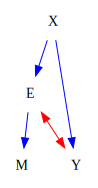

In [4]:
graph.draw()

In [5]:
df = load_wisconsin_health_study()


In [6]:
df.head()

,X,E,M,Y,count
0,0,0,0,0,241
1,0,0,0,1,162
2,0,0,1,0,53
3,0,0,1,1,39
4,1,0,0,0,161


## Investigating the causal effect of X on Y

As detailed in [4], we investigate the causal effect of family income in 1957 on respondent income in 1992.

In [7]:
X = binary_nested.process_data(df=df, count_variable='count')

In [8]:
X

array([241, 162, 161, 148,  53,  39,  33,  29,  82, 176, 113, 364,  13,
        16,  16,  30])

In [9]:
bnm = binary_nested.BinaryNestedModel(graph)

In [10]:
bnm = bnm.fit(X=X)

/Users/jaron/Projects/ananke/ananke/models/binary_nested.py:511: RuntimeWarning: invalid value encountered in log
  logger.debug(np.log(A @ x - b))
/Users/jaron/Projects/ananke/ananke/models/binary_nested.py:512: RuntimeWarning: invalid value encountered in log
  lld = np.sum(counts * np.log(A @ x - b))


In [11]:
bnm.fitted_params

OrderedDict([((frozenset({'E'}), ('X',), (0,)), 0.6329923225577604),
             ((frozenset({'E'}), ('X',), (1,)), 0.41498894592949687),
             ((frozenset({'E', 'Y'}), ('X',), (0,)), 0.37595907634663206),
             ((frozenset({'E', 'Y'}), ('X',), (1,)), 0.21700230650140587),
             ((frozenset({'M'}), ('E',), (0,)), 0.8221708988986646),
             ((frozenset({'M'}), ('E',), (1,)), 0.9074074044189431),
             ((frozenset({'X'}), (), ()), 0.4665871121546948),
             ((frozenset({'Y'}), ('X',), (0,)), 0.49744245337806176),
             ((frozenset({'Y'}), ('X',), (1,)), 0.36129757488088415)])

We attempt to estimate the average causal effect of $X$ on $Y$. This is given by

$$p(Y=1 | do(X=1)) - p(Y=1 | do(X=0)) = (1 - \theta_Y (X=1)) - (1 - \theta_Y (X=0)) $$

In [12]:
pY1_X1 = (1 - bnm.fitted_params[(frozenset({'Y'}), ('X', ), (1,))])
pY1_X1

0.6387024251191158

In [13]:
pY1_X0 = (1 - bnm.fitted_params[(frozenset({'Y'}), ('X', ), (0,))])
pY1_X0

0.5025575466219383

In [14]:
pY1_X1 - pY1_X0

0.1361448784971775

Interestingly, we do not recover the result in [4], in which $p(Y=1 | do(X=1))  = 0.50$ and $p(Y=1 | do(X=0)) = 0.36$. However, we obtain a similar looking result if $X \equiv 1 - X$ and $Y \equiv 1 - Y$:

In [15]:
df_flip = df.copy()

In [16]:
df_flip["X"] = 1 - df_flip["X"]
df_flip["Y"] = 1 - df_flip["Y"]

In [17]:
bnm_flip = binary_nested.BinaryNestedModel(graph)
X_flip = binary_nested.process_data(df=df_flip, count_variable='count')
bnm_flip = bnm.fit(X=X_flip)

In [18]:
pY1_X1_flip = (1 - bnm_flip.fitted_params[(frozenset({'Y'}), ('X', ), (1,))])
pY1_X0_flip = (1 - bnm_flip.fitted_params[(frozenset({'Y'}), ('X', ), (0,))])


In [19]:
pY1_X1_flip

0.4974424530066138

In [20]:
pY1_X0_flip

0.36129757712073496

Given the unit testing coverage of `ananke` we have reason to believe that some error has occurred in the application section of [3]. 

## Analysing the effect of E on Y

While investigating the causal effect of $X$ on $Y$ is interesting, it does not lead to policy changes since intervening on income in the past is not feasible. However, intervening on whether a student has education after high school is something that can feasibly be affected through policy changes. Thus, we consider the effect of $X$ on $Y$.

In [21]:
graph = ADMG(vertices=['E', 'M', 'Y'], 
             di_edges=[('E', 'M'), ('M', 'Y')], 
             bi_edges=[('E', 'Y')])
bnm = binary_nested.BinaryNestedModel(graph)

In [22]:
df = load_wisconsin_health_study().groupby(["E", "M", "Y"])["count"].sum().reset_index()

In [23]:
df 

,E,M,Y,count
0,0,0,0,402
1,0,0,1,310
2,0,1,0,86
3,0,1,1,68
4,1,0,0,195
5,1,0,1,540
6,1,1,0,29
7,1,1,1,46


In [24]:
df["E"].mean()

0.5

In [25]:
df.groupby(["M", "Y"])["count"].sum()

M  Y
0  0    597
   1    850
1  0    115
   1    114
Name: count, dtype: int64

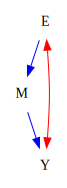

In [26]:
graph.draw()

In [27]:
bnm = bnm.fit(X=df, tol=1e-12)

/Users/jaron/Projects/ananke/ananke/models/binary_nested.py:511: RuntimeWarning: invalid value encountered in log
  logger.debug(np.log(A @ x - b))
/Users/jaron/Projects/ananke/ananke/models/binary_nested.py:512: RuntimeWarning: invalid value encountered in log
  lld = np.sum(counts * np.log(A @ x - b))


We attempt to estimate the average causal effect of $E$ on $Y$. Recall that the front-door identification formula in general is given as 

$$ p(Y(e)) = \sum_m q(Y| M=m, E=e) q(M=m| E=e)$$

where $q$ here denotes Markov kernels. It turns out that $q(Y |M, E)$ is not a function of $E$ after $M$ has been fixed, so this is equal to $q(Y | M)$. Then,

$$ p(Y(e)) = \sum_m q(Y| M=m) q(M=m| E=e)$$

Furthermore, note that the Mobius parameters are kernels which are evaluated at the reference value (zero).

$$p(Y=1 | do(X=E)) = (1 - \theta_Y (M=0))(\theta_M (E=e)) + (1 - \theta_Y (M=1))* (1 - \theta_M (E=e)) $$




In [28]:
bnm.fitted_params

OrderedDict([((frozenset({'E'}), (), ()), 0.5167064529214306),
             ((frozenset({'E', 'Y'}), ('M',), (0,)), 0.2917359440408035),
             ((frozenset({'E', 'Y'}), ('M',), (1,)), 0.2885503638292143),
             ((frozenset({'M'}), ('E',), (0,)), 0.8221709018146659),
             ((frozenset({'M'}), ('E',), (1,)), 0.907407405514132),
             ((frozenset({'Y'}), ('M',), (0,)), 0.4199566848971338),
             ((frozenset({'Y'}), ('M',), (1,)), 0.47542389281964714)])

In [29]:
theta_M0_E0 = bnm.fitted_params[(frozenset({'M'}), ('E',), (0,))]
theta_M0_E1 = bnm.fitted_params[(frozenset({'M'}), ('E',), (1,))]
theta_Y0_M0 = bnm.fitted_params[(frozenset({'Y'}), ('M',), (0,))]
theta_Y0_M1 = bnm.fitted_params[(frozenset({'Y'}), ('M',), (1,))]

In [30]:
pY1_E0 = (1 - theta_Y0_M0) * theta_M0_E0 + (1 - theta_Y0_M1) * (1 - theta_M0_E0)

In [31]:
pY1_E1 = (1 - theta_Y0_M0) * theta_M0_E1 + (1 - theta_Y0_M1) * (1 - theta_M0_E1)

In [32]:
pY1_E1 -  pY1_E0

0.004727830873286432